In [ ]:
new_nb("2024-05-29__STA-winlength")

In [1]:
include("lib/Nto1.jl")

using Revise … ✔ (0.2 s)
using Units, Nto1AdEx, ConnectionTests, ConnTestEval, MemDiskCache … ✔ (0.4 s)
using StatsBase … ✔


In [2]:
duration = 10minutes

600

---

In [3]:
ConnectionTests.STA_length = 1000;

In [4]:
Ns = [5, 20, 100, 400, 1600, 6500]
seeds = 1:5;

In [5]:
conntypes(inputs) = begin
    conntypes = []
    for (conntype, trains) in inputs
        append!(conntypes, repeat([conntype], length(trains)))
    end
    conntypes
end;

In [6]:
MemDiskCache.set_dir("2024-05-26__Fix_template-based_method")

"C:\\Users\\tfiers\\.julia\\MemDiskCache.jl\\2024-05-26__Fix_template-based_method"

In [8]:
rows_STA_longwin() = begin
    rows = []
    for N in Ns
        for seed in seeds
            @show N seed
            sim = Nto1AdEx.sim(N, duration; seed);
            ((_, exc),
             (_, inh),
             (_, unc)) = inputs = get_trains_to_test(sim, Nₜ = length(sim.trains));
            all_trains = [exc; inh; unc]
            tvals = []
            @showprogress for train in all_trains
                push!(tvals, STA_test(sim.V, train.times))
            end
            push!(rows, (; N, seed, tvals, conntypes=conntypes(inputs)))
        end
    end
    rows
end

rows = @cached rows_STA_longwin()

Running rows_STA_longwin() … 
N = 5
seed = 1
Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
N = 5
seed = 2
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
N = 5
seed = 3
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
N = 5
seed = 4
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
N = 5
seed = 5
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
N = 20
seed = 1
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
N = 20
seed = 2
Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
N = 20
seed = 3
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
N = 20
seed = 4
Progress: 100%|█████████████████████████████████████████| Time: 0:00:05
N = 20
seed = 5
Progress: 100%|█████████████████████████████████████████| Time: 0:00:05
N = 100
seed = 1
Progress: 100%|█████████████████████████████████████████| Time: 0:00:22
N = 10

30-element Vector{Any}:
 (N = 5, seed = 1, tvals = Any[0.99, 0.99, 0.99, 0.99, -0.99, -0.13, -0.8, -0.37, 0.28, 0.14], conntypes = Any[:exc, :exc, :exc, :exc, :inh, :unc, :unc, :unc, :unc, :unc])
 (N = 5, seed = 2, tvals = Any[0.99, 0.99, 0.99, 0.99, -0.99, 0.55, 0.27, 0.13, 0.43, 0.58], conntypes = Any[:exc, :exc, :exc, :exc, :inh, :unc, :unc, :unc, :unc, :unc])
 (N = 5, seed = 3, tvals = Any[0.99, 0.99, 0.99, 0.99, -0.99, -0.8, 0.45, 0.61, -0.19, 0.97], conntypes = Any[:exc, :exc, :exc, :exc, :inh, :unc, :unc, :unc, :unc, :unc])
 (N = 5, seed = 4, tvals = Any[0.99, 0.99, 0.99, 0.99, -0.99, 0.59, -0.45, 0.74, -0.54, -0.44], conntypes = Any[:exc, :exc, :exc, :exc, :inh, :unc, :unc, :unc, :unc, :unc])
 (N = 5, seed = 5, tvals = Any[0.99, 0.99, 0.99, 0.99, -0.99, 0.97, 0.87, 0.69, -0.49, -0.3], conntypes = Any[:exc, :exc, :exc, :exc, :inh, :unc, :unc, :unc, :unc, :unc])
 (N = 20, seed = 1, tvals = Any[0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99  …  0.67, 0.71, 0.29, 0.1, 0

3h20, phew.

---

In [12]:
perfrows = []
for row in rows
    (; N, seed, tvals) = row
    sweep = sweep_threshold(tvals, row.conntypes)
    AUC = calc_AUROCs(sweep).AUC
    F1max = maximum(skipnan(sweep.F1))
    push!(perfrows, (; N, seed, method="STA-longwin", AUC, F1max))
end;

In [13]:
include("lib/df.jl")

using DataFrames … ✔ (0.6 s)


In [24]:
perfrows_prevnb = @cached "perfrows" blah;

Loading [C:\Users\tfiers\.julia\MemDiskCache.jl\2024-05-26__Fix_template-based_method\perfrows.jld2] … ✔ (3.3 s)


In [25]:
perfrows_both = [perfrows; perfrows_prevnb];

In [34]:
df = DataFrame(perfrows_both);

In [36]:
gdf = groupby(df[df.method.=="STA-longwin",:], :N)
combine(gdf, nrow => :num_seeds, [:AUC, :F1max] .=> mean)

Row,N,num_seeds,AUC_mean,F1max_mean
,Int64,Int64,Float64,Float64
1,5,5,1,1
2,20,5,0.965,0.985
3,100,5,0.908,0.915
4,400,5,0.581,0.546
5,1600,5,0.329,0.328
6,6500,5,0.242,0.327


In [18]:
include("lib/plot.jl")

import PythonCall … ✔
import PythonPlot … ✔
using Sciplotlib … ✔
using PhDPlots … ✔


In [20]:
chance_AUC = 0.252;

Saved at `../thesis/figs/perf-STA-winlength.pdf`

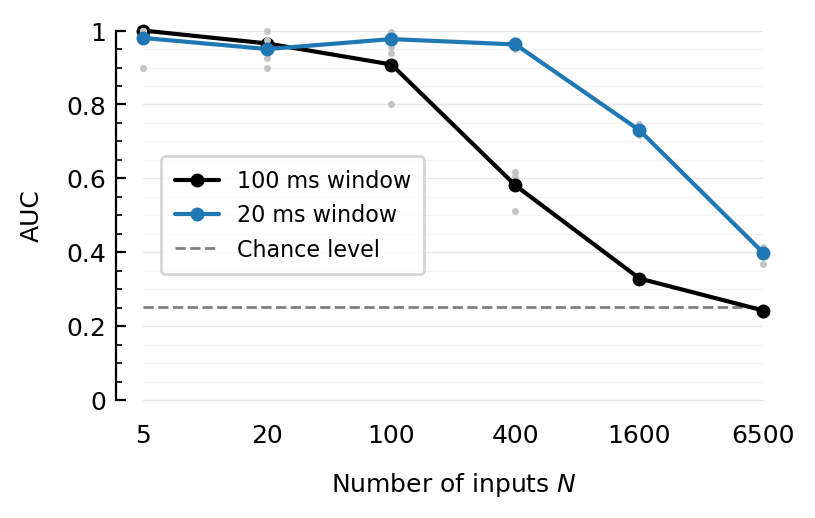

In [41]:
ax = newax()
plotAUC(ax, m; kw...) = begin
    plot_dots_and_means(
        df[df.method.==m, :], :N, :AUC;
        ax,
        xtype=:categorical, xticklabels=Ns,
        ylim=[0,1],
        xlabel = L"Number of inputs $N$",
        kw...
    )
end
add_chance_line(ax) = ax.axhline(chance_AUC, ls="--", lw=1, color="gray", label="Chance level")
add_chance_line(ax)
plotAUC(ax, "STA-longwin", line_label="100 ms window");
plotAUC(ax, "STA", line_label="20 ms window", color_means=C0);
legend(ax, reorder=[1=>3])
savefig_phd("perf-STA-winlength");

---

"Numerical fixed point".\
Size of exponential term in eq 1.

In [43]:
(; gₗ, Δₜ, Vₜ, Eₗ) = Nto1AdEx;

In [44]:
exp_term(V) = gₗ*Δₜ*exp((V-Vₜ)/Δₜ)
exp_term(Eₗ)

3.01E-19

Units are.. SI.\
Let's do in mV/ms eg.\
Will be same :)

In [45]:
eps(Float64)

2.22E-16